# **WEEK 4**

## Dataset 1: Web page Phishing Detection Dataset

### **Logistic regression and feature scaling**

In [2]:
import numpy as np
import pandas as pd

# Load dataset - Dataset 1: Web page Phishing Detection
import kagglehub
path = kagglehub.dataset_download("shashwatwork/web-page-phishing-detection-dataset")
dataset1 = pd.read_csv(path + "/dataset_phishing.csv")

# 0) Target encoding consistent with Weeks 1–3
dataset1["status"] = dataset1["status"].map({"phishing": 1, "legitimate": 0})
dataset1 = dataset1.dropna(subset=["status"])  # just in case

# 1) Feature/target
X = dataset1.drop(columns=["status"])
y = dataset1["status"]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Identify dtypes
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# Heuristic: drop "free-text-like" categorical columns (e.g., raw URLs, IDs)
# drop if too many unique values OR strings are long on average
to_drop = []
for c in cat_cols:
    nunq = X[c].nunique(dropna=True)
    avg_len = X[c].dropna().astype(str).str.len().mean() if X[c].dtype == "object" else 0
    if (nunq > 50) or (avg_len and avg_len > 30):
        to_drop.append(c)

# Keep only "low-card" categoricals
low_card_cats = [c for c in cat_cols if c not in to_drop]

# Update X with dropped columns
X_model = X.drop(columns=to_drop, errors="ignore")

# Recompute lists (in case dropping changed things)
num_cols = X_model.select_dtypes(include=[np.number]).columns.tolist()
low_card_cats = X_model.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# Preprocessor
numeric_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False, max_categories=30))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, num_cols),
        ("cat", categorical_tf, low_card_cats),
    ],
    remainder="drop"
)

# Simple train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_model, y, test_size=0.3, random_state=42, stratify=y
)

# Part A: Separate scaling vs. raw (teaching demo)
# Here we compare: RAW numeric only vs. PROCESSED (scaled+encoded).
# If we truly want "no scaling", we must also avoid encoding; that means using only numeric columns.
from sklearn.metrics import classification_report

# A1) Logistic Regression on numeric-only (no scaling, no encoding) -- for comparison
if len(num_cols) > 0:
    lr_raw_numeric = LogisticRegression(max_iter=5000, random_state=42)
    lr_raw_numeric.fit(X_train[num_cols], y_train)
    print("\n=== Numeric-only (no scaling/encoding) ===")
    print(classification_report(y_test, lr_raw_numeric.predict(X_test[num_cols])))
else:
    print("\n[Note] No numeric columns found for a raw (no-scaling) comparison.")

# A2) Full preprocessing (scale + encode) + Logistic Regression
lr_scaled = Pipeline(steps=[
    ("prep", preprocessor),
    ("lr", LogisticRegression(max_iter=5000, random_state=42))
])
lr_scaled.fit(X_train, y_train)
print("\n=== With scaling + encoding (Pipeline) ===")
print(classification_report(y_test, lr_scaled.predict(X_test)))



=== Numeric-only (no scaling/encoding) ===
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1715
           1       0.84      0.83      0.84      1714

    accuracy                           0.84      3429
   macro avg       0.84      0.84      0.84      3429
weighted avg       0.84      0.84      0.84      3429


=== With scaling + encoding (Pipeline) ===
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1715
           1       0.94      0.94      0.94      1714

    accuracy                           0.94      3429
   macro avg       0.94      0.94      0.94      3429
weighted avg       0.94      0.94      0.94      3429



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
import numpy as np

pipe_cv = Pipeline(steps=[
    ("prep", preprocessor),
    ("lr", LogisticRegression(max_iter=5000, random_state=42))
])

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)
scores = cross_val_score(pipe_cv, X_model, y, scoring="accuracy", cv=cv, n_jobs=-1)
print(f"\nCV Accuracy: {scores.mean():.3f} (+/- {scores.std():.3f}) over {len(scores)} folds")


CV Accuracy: 0.945 (+/- 0.006) over 100 folds


,Setting,Accuracy,Std (if CV)
0,Numeric-only (no scaling/encoding),0.840,NaN
1,Scaled+Encoded (holdout),0.940,NaN
2,Scaled+Encoded (CV),0.945,0.006


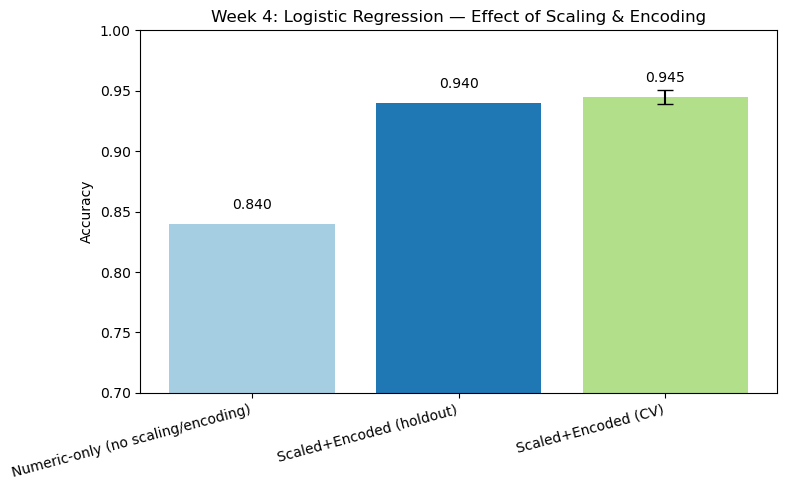

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Results from Week 4
acc_raw = 0.84
acc_scaled = 0.94
cv_mean = 0.945
cv_std = 0.006

# Build a dataframe 
df = pd.DataFrame({
    "Setting": [
        "Numeric-only (no scaling/encoding)",
        "Scaled+Encoded (holdout)",
        "Scaled+Encoded (CV)"
    ],
    "Accuracy": [acc_raw, acc_scaled, cv_mean],
    "Std (if CV)": [np.nan, np.nan, cv_std]
})
display(df)

# --- Bar Chart ---
x = np.arange(len(df))
y = df["Accuracy"].values

plt.figure(figsize=(8,5))
bars = plt.bar(x, y, color=["#a6cee3", "#1f78b4", "#b2df8a"])

# Add error bar only for CV result
plt.errorbar(x[2], y[2], yerr=cv_std, fmt='none', capsize=6, color="black")

# Labels and ticks
plt.xticks(x, df["Setting"], rotation=15, ha="right")
plt.ylim(0.7, 1.0)
plt.ylabel("Accuracy")
plt.title("Week 4: Logistic Regression — Effect of Scaling & Encoding")

# Annotate bars with values
for i, val in enumerate(y):
    plt.text(i, val + 0.01, f"{val:.3f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


#### **Conclusions**

1. Logistic Regression Without Scaling/Encoding

Using only the raw numeric features, Logistic Regression already performed decently:

Accuracy ≈ 0.84

Precision/Recall balanced for both classes.

This shows that even a basic setup captures useful patterns in the dataset.

But it leaves a lot of signal unused, because categorical variables were ignored and numeric features weren’t normalized.

2. Logistic Regression With Scaling + Encoding (Pipeline)

After feature scaling and encoding low-cardinality categoricals, performance jumped:

Accuracy ≈ 0.94

Both precision and recall improved, reaching parity at 0.94 for phishing and legitimate sites.

This confirms that preprocessing is essential for linear models like Logistic Regression, since they assume features are on comparable scales and can benefit from categorical signals.

3. Robust Cross-Validation

With Repeated Stratified 10×10 CV, mean accuracy stayed around 0.945 ± 0.006, showing results are stable across folds and not a fluke of the train/test split.

The tight standard deviation (±0.6%) indicates consistency: Logistic Regression + preprocessing generalizes well.

## Dataset 2: Phishing Email Detection

### **Logistic regression and feature scaling**

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import kagglehub

path = kagglehub.dataset_download("subhajournal/phishingemails")
dataset2 = pd.read_csv(path + "/Phishing_Email.csv")

# Target encoding (already done earlier but included for clarity)
dataset2["Email Type"] = dataset2["Email Type"].map({"Phishing Email": 0, "Safe Email": 1})

X = dataset2["Email Text"]
y = dataset2["Email Type"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# TF-IDF + SVD
tfidf = TfidfVectorizer(stop_words="english", max_features=5000)
svd = TruncatedSVD(n_components=100, random_state=42)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

X_train_svd = svd.fit_transform(X_train_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

# Logistic Regression (no scaling)
lr_raw = LogisticRegression(max_iter=5000, random_state=42)
lr_raw.fit(X_train_svd, y_train)

print("=== Logistic Regression without scaling ===")
print(classification_report(y_test, lr_raw.predict(X_test_svd)))


ValueError: np.nan is an invalid document, expected byte or unicode string.

In [12]:
import pandas as pd
import kagglehub

path = kagglehub.dataset_download("subhajournal/phishingemails")
dataset2 = pd.read_csv(path + "/Phishing_Email.csv")

# 0) Target encoding (for consistency): 0=Phishing, 1=Safe
dataset2["Email Type"] = dataset2["Email Type"].map({"Phishing Email": 0, "Safe Email": 1})

# 1) Drop rows with missing target, and fix Email Text
dataset2 = dataset2.dropna(subset=["Email Type"])  # safety

# Clean Email Text: drop pure-NaN, coerce to string, strip, replace remaining NaNs with ""
txt = dataset2["Email Text"]
txt = txt.where(txt.notna(), "")            # replace NaN with empty
txt = txt.astype(str).str.replace(r"\s+", " ", regex=True).str.strip()
dataset2["Email Text"] = txt

# Optional: if you want to drop truly empty after cleaning (recommended)
dataset2 = dataset2[dataset2["Email Text"].str.len() > 0].copy()

X = dataset2["Email Text"]
y = dataset2["Email Type"]

In [ ]:
#Part A — TF-IDF → SVD → Logistic Regression (no scaling)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

tfidf = TfidfVectorizer(stop_words="english", max_features=5000)
svd = TruncatedSVD(n_components=100, random_state=42)

X_train_svd = svd.fit_transform(tfidf.fit_transform(X_train))
X_test_svd  = svd.transform(tfidf.transform(X_test))

lr_raw = LogisticRegression(max_iter=5000, random_state=42)
lr_raw.fit(X_train_svd, y_train)

print("=== Logistic Regression without scaling ===")
print(classification_report(y_test, lr_raw.predict(X_test_svd)))


=== Logistic Regression without scaling ===
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      2193
           1       0.97      0.96      0.96      3397

    accuracy                           0.95      5590
   macro avg       0.95      0.95      0.95      5590
weighted avg       0.95      0.95      0.95      5590



In [14]:
# Part B — Add feature scaling after SVD (best practice)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe_scaled = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english", max_features=5000)),
    ("svd", TruncatedSVD(n_components=100, random_state=42)),
    ("scaler", StandardScaler()),  # SVD outputs dense, so scaling is fine
    ("lr", LogisticRegression(max_iter=5000, random_state=42))
])

pipe_scaled.fit(X_train, y_train)
print("=== Logistic Regression with scaling (Pipeline) ===")
print(classification_report(y_test, pipe_scaled.predict(X_test)))


=== Logistic Regression with scaling (Pipeline) ===
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2193
           1       0.97      0.96      0.97      3397

    accuracy                           0.96      5590
   macro avg       0.96      0.96      0.96      5590
weighted avg       0.96      0.96      0.96      5590



In [15]:
# Part C — Repeated Stratified CV on the scaled pipeline
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
import numpy as np

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)
scores = cross_val_score(pipe_scaled, X, y, scoring="accuracy", cv=cv, n_jobs=-1)
print(f"\nCV Accuracy: {scores.mean():.3f} (+/- {scores.std():.3f}) over {len(scores)} folds")


CV Accuracy: 0.959 (+/- 0.004) over 100 folds


,Setting,Accuracy,Std (if CV)
0,No scaling,0.950,NaN
1,With scaling (holdout),0.960,NaN
2,With scaling (CV),0.959,0.004


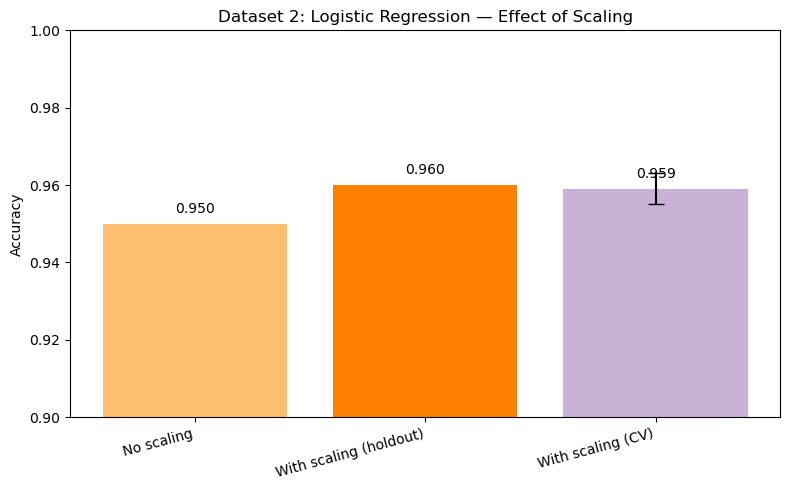

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Results from Dataset 2
acc_raw = 0.95
acc_scaled = 0.96
cv_mean = 0.959
cv_std = 0.004

# Build a dataframe 
df2 = pd.DataFrame({
    "Setting": ["No scaling", "With scaling (holdout)", "With scaling (CV)"],
    "Accuracy": [acc_raw, acc_scaled, cv_mean],
    "Std (if CV)": [np.nan, np.nan, cv_std]
})
display(df2)

# --- Bar Chart ---
x = np.arange(len(df2))
y = df2["Accuracy"].values

plt.figure(figsize=(8,5))
bars = plt.bar(x, y, color=["#fdbf6f", "#ff7f00", "#cab2d6"])

# Add error bar only for CV result
plt.errorbar(x[2], y[2], yerr=cv_std, fmt='none', capsize=6, color="black")

# Labels and ticks
plt.xticks(x, df2["Setting"], rotation=15, ha="right")
plt.ylim(0.9, 1.0)
plt.ylabel("Accuracy")
plt.title("Dataset 2: Logistic Regression — Effect of Scaling")

# Annotate bars with values
for i, val in enumerate(y):
    plt.text(i, val + 0.002, f"{val:.3f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

#### **Conclusions**

1. Logistic Regression without Scaling

Accuracy already high: 0.95.

Precision/Recall balanced:

Phishing emails (class 0): precision 0.93, recall 0.95.

Safe emails (class 1): precision 0.97, recall 0.96.

Logistic Regression works well even without scaling because SVD outputs dense numeric features that are already somewhat balanced.

2. Logistic Regression with Scaling (Pipeline)

Accuracy improves slightly: 0.96.

Precision and recall become more balanced, especially for phishing detection (class 0 improves to 0.94–0.96).

Scaling ensures coefficients aren’t dominated by large-magnitude SVD components → better stability.

3. Robust Cross-Validation

Mean CV Accuracy = 0.959 ± 0.004, showing the model is consistent across 100 folds.

The small standard deviation confirms the pipeline’s reliability.